import

In [2]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [3]:
class_names = ['Dent', 'Other', 'Rim', 'Scratch']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (236,255)

loading the data

In [4]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['splitted_folder/train', 'splitted_folder/val']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading splitted_folder/train


100%|██████████| 224/224 [00:00<00:00, 814.57it/s]


Loading splitted_folder/val


100%|██████████| 56/56 [00:00<00:00, 954.48it/s]


In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

explore the dataset

In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 717
Number of testing examples: 180
Each image is of size: (236, 255)


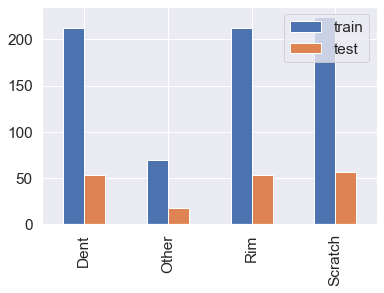

In [8]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

scale the data

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

visualize the data

In [10]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

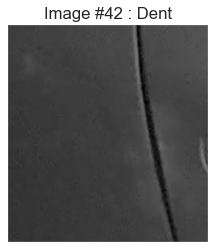

In [11]:
display_random_image(class_names, train_images, train_labels)

In [12]:
def display_examples(class_names, images, labels, title):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(title, fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

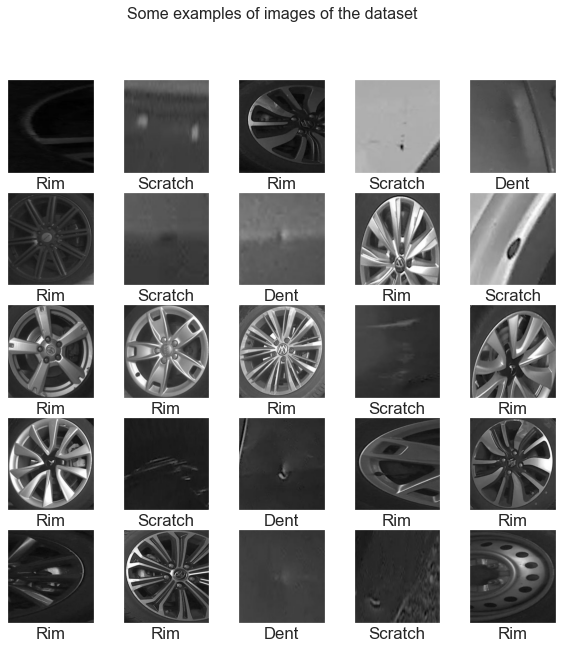

In [13]:
display_examples(class_names, train_images, train_labels,"Some examples of images of the dataset")

Feature extraction

In [14]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet101
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.inception_v3 import InceptionV3#0.8056 0.8111111111111111
from keras.applications.inception_resnet_v2 import InceptionResNetV2#0.7889 0.7722222222222223
from keras.applications.mobilenet import MobileNet#0.7889 0.7777777777777778
from keras.applications.mobilenet_v2 import MobileNetV2#0.7944 0.7722222222222223
from keras.applications.densenet import DenseNet121#0.7889 0.7722222222222223
from keras.applications.densenet import DenseNet169#0.8111 0.7833333333333333
from keras.applications.densenet import DenseNet201#0.0.7944 0.7722222222222223
from keras.applications.efficientnet import EfficientNetB0#0.2944 0.46111111111111114

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = InceptionV3(weights='imagenet', include_top=False)

In [15]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

Visualize the features through PCA

In [16]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [17]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) 
C1 = C[:,0]
C2 = C[:,1]

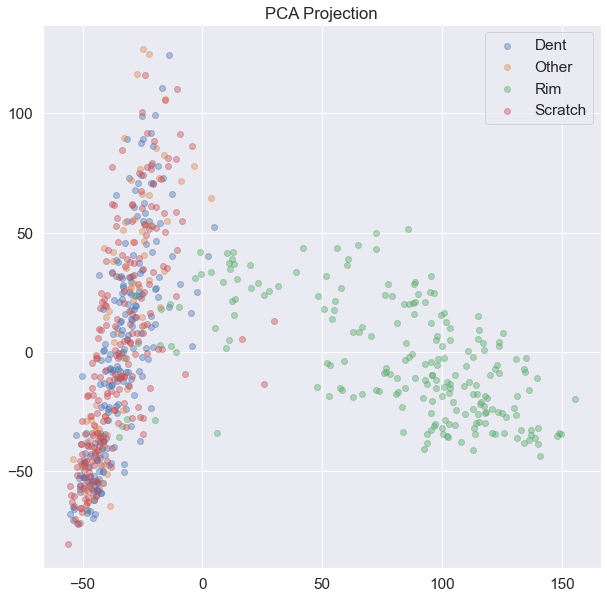

In [18]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

We see that there is no distinction between dent and scratch.

Classification

In [19]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'nadam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])#adagrad0.81,nadam0.82

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=150, validation_split = 0.2)

Epoch 1/150
5/5 [==============================] - 2s 134ms/step - loss: 1.5208 - accuracy: 0.5131 - val_loss: 3.7425 - val_accuracy: 0.4167
Epoch 2/150
5/5 [==============================] - 1s 120ms/step - loss: 0.6100 - accuracy: 0.8168 - val_loss: 3.5224 - val_accuracy: 0.3125
Epoch 3/150
5/5 [==============================] - 1s 117ms/step - loss: 0.3940 - accuracy: 0.9075 - val_loss: 2.2140 - val_accuracy: 0.5208
Epoch 4/150
5/5 [==============================] - 1s 106ms/step - loss: 0.2807 - accuracy: 0.9494 - val_loss: 2.0846 - val_accuracy: 0.5486
Epoch 5/150
5/5 [==============================] - 1s 109ms/step - loss: 0.2183 - accuracy: 0.9703 - val_loss: 2.1294 - val_accuracy: 0.4861
Epoch 6/150
5/5 [==============================] - 1s 114ms/step - loss: 0.1577 - accuracy: 0.9860 - val_loss: 1.5119 - val_accuracy: 0.6458
Epoch 7/150
5/5 [==============================] - 0s 101ms/step - loss: 0.1292 - accuracy: 0.9948 - val_loss: 1.4633 - val_accuracy: 0.6597
Epoch 8/150
5

In [20]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

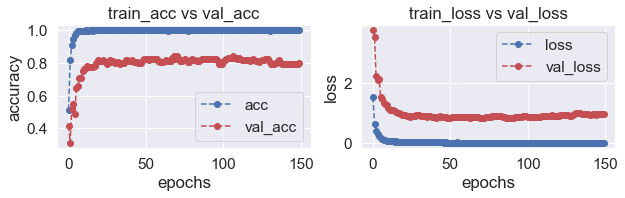

In [21]:
plot_accuracy_loss(history2)

evaluation

In [22]:
test_loss = model2.evaluate(test_features, test_labels)

6/6 [==============================] - 0s 7ms/step - loss: 1.3258 - accuracy: 0.7833


In [23]:
model2.save('checkpoint/mymodel.h5',save_format='h5')

In [24]:
from keras.models import load_model
model3=load_model('checkpoint/mymodel.h5')

In [25]:
test_loss = model3.evaluate(test_features, test_labels)

6/6 [==============================] - 0s 7ms/step - loss: 1.3258 - accuracy: 0.7833


In [26]:
predictions = []
predictions.append(model3.predict(test_features))
  
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

In [27]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)[0]
    len_mislabeled = len(mislabeled_indices)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    true_labels = test_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_mis_examples(class_names,  mislabeled_images, mislabeled_labels, true_labels, title, len_mislabeled)

In [28]:
def display_mis_examples(class_names, images, labels, true_labels, title, len_mislabeled):
    """
        Display n images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,22))
    fig.suptitle(title, fontsize=16)
    for i in range(len_mislabeled):
        plt.subplot(10,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel('predicted: ' + str(class_names[labels[i]])+ '\n' +' true: ' + str(class_names[true_labels[i]]), fontsize=11)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

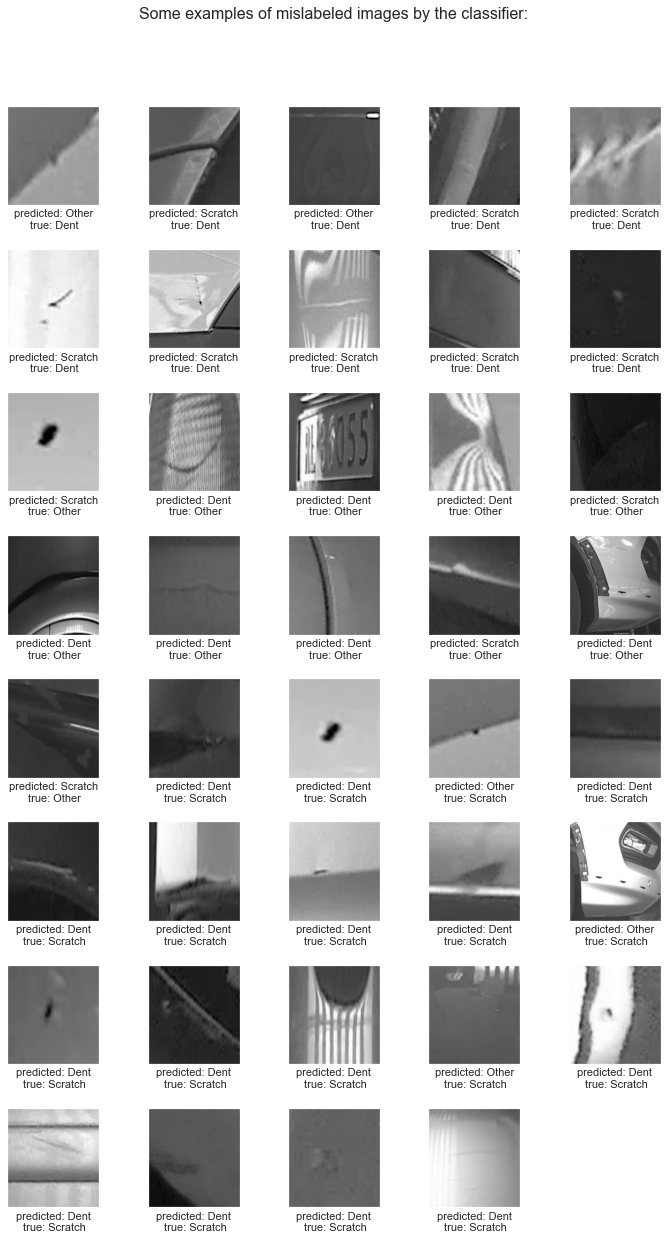

In [29]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)